<a href="https://colab.research.google.com/github/bharathkreddy/brks_agents/blob/main/finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [109]:
!pip install python-dotenv
!pip install datasets==3.6.0 # for ValueError: doesn't have a 'trust_remote_code' key. (load_dataset)

In [2]:
# imports

import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt

In [3]:
# from google.colab import userdata
# HF_TOKEN = userdata.get('HUGGINGFACE_API_KEY')
# login(HF_TOKEN, add_to_git_credential=True)

load_dotenv()
HF_TOKEN=os.getenv('HUGGINGFACE_API_KEY')
login(HF_TOKEN, add_to_git_credential=True)

In [4]:
# data from https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_Appliances", split="full", trust_remote_code=True)

In [5]:
for idx,item in enumerate(dataset):
  if idx>2:
    break
  print(item)

{'main_category': 'Industrial & Scientific', 'title': 'ROVSUN Ice Maker Machine Countertop, Make 44lbs Ice in 24 Hours, Compact & Portable Ice Maker with Ice Basket for Home, Office, Kitchen, Bar (Silver)', 'average_rating': 3.7, 'rating_number': 61, 'features': ['【Quick Ice Making】This countertop ice machine creates crystal & bullet shaped ice cubes; 44lbs of ice ready in 24 hours, 12 cubes made per cycle within 10 mins; you can perfectly use it for drinks, wine, smoothies, food', '【Portable Design】The weight of this ice maker is only 23.3lbs, and the small size (10.63 x14.37 x 12.87)" makes it portable. It\'s compact feature is perfect for home, office, apartments, dormitories, RVs and more, it can be placed on countertop or tabletop, plug it anywhere you like', '【Simple Operation】Adding the water tank with purified water; Power on machine and press "on/off" button to start ice making process; After 8-12 minutes, ice cube will fall off into the ice basket automatically; Take it out a

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### We want a subset of this dataset which has prices and item description. So lets check what % of the dataset has price field available. Note this is pyArrow table and not a list of dictionanries and hence we should use pyarrow based operations, I resisted the urge to load this on pandas dataframe to investigate as this would have eaten up my RAM.


In [7]:
# import importlib
# import items  # this assumes you've already imported it once
# importlib.reload(items)
# i did above as i was constantly re-factoring items.py file but otherwise no need to reload the module as its an expensive operation
from items import Item  # re-import class from the updated module
from loaders import ItemLoader

In [12]:
dataset_names = [
    # "Automotive",
    # "Electronics",
    # "Office_Products",
    # "Tools_and_Home_Improvement",
    # "Cell_Phones_and_Accessories",
    # "Toys_and_Games",
    "Appliances",
    "Musical_Instruments",
]

In [13]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

Loading dataset Appliances


100%|██████████| 95/95 [00:16<00:00,  5.83it/s]


Completed Appliances with 28,625 datapoints in 0.3 mins
Loading dataset Musical_Instruments


meta_Musical_Instruments.jsonl:   0%|          | 0.00/632M [00:00<?, ?B/s]

Generating full split:   0%|          | 0/213593 [00:00<?, ? examples/s]

100%|██████████| 214/214 [00:28<00:00,  7.41it/s]


Completed Musical_Instruments with 66,829 datapoints in 2.1 mins


In [14]:
print(f"A grand total of {len(items):,} items")

A grand total of 95,454 items


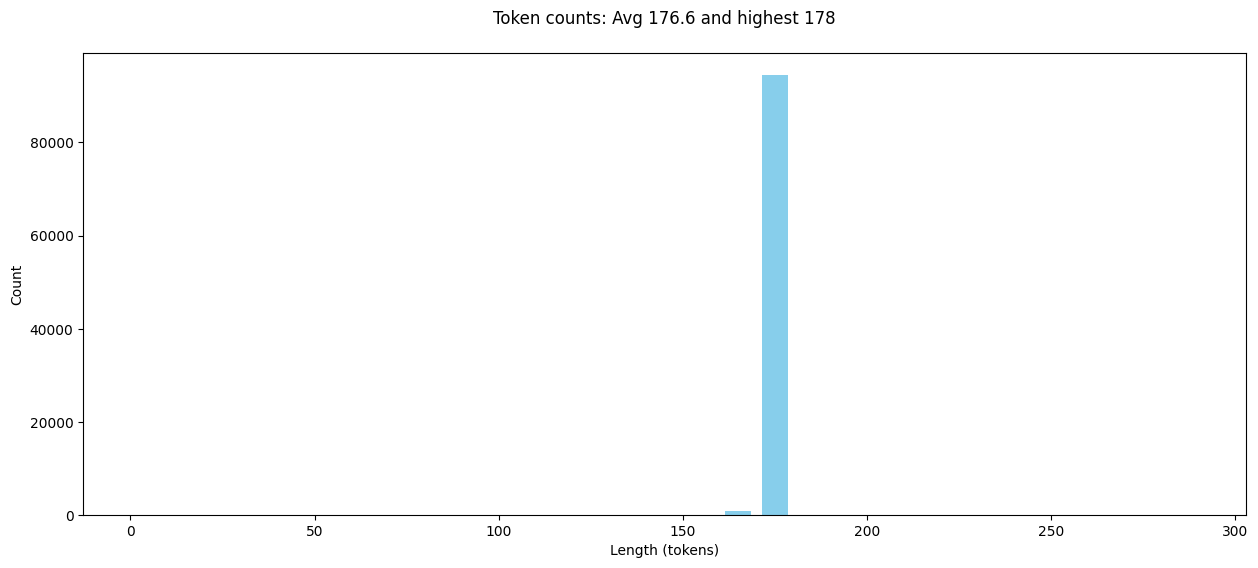

In [15]:
# Plot the distribution of token counts again

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

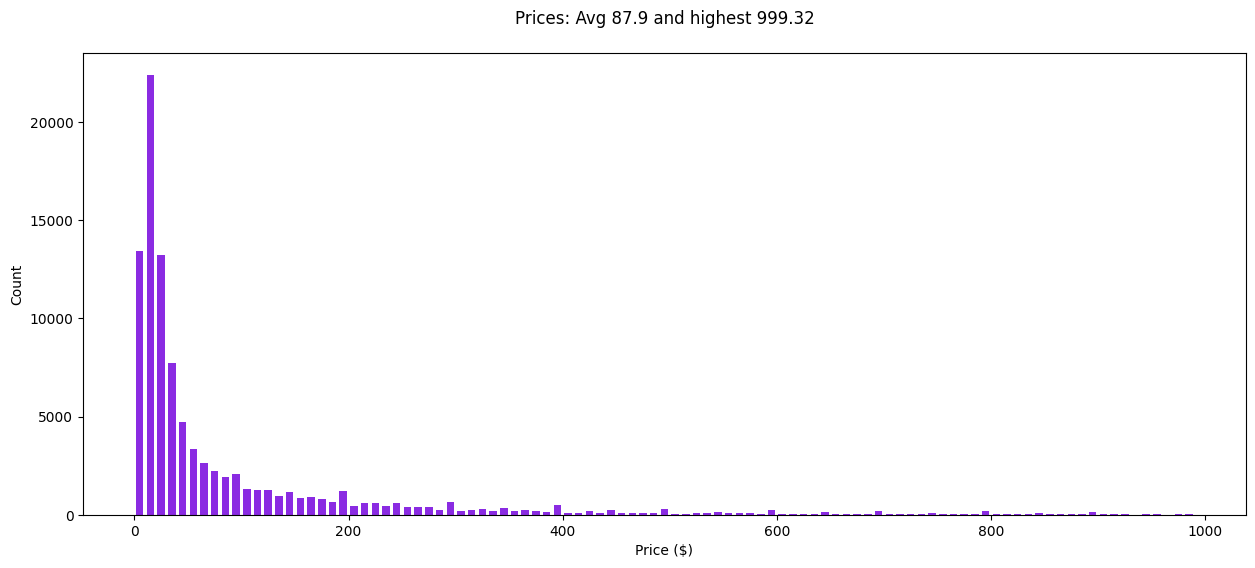

In [16]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

(array([ 5067., 10898.,  7582.,  4491.,  2564.,  1774.,  1355.,  1099.,
          851.,   753.,   495.,   475.,   412.,   349.,   327.,   284.,
          250.,   222.,   224.,   264.,   125.,   139.,   135.,   131.,
          138.,    91.,    98.,    91.,    60.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
        220., 230., 240., 250., 260., 270., 280., 290.]),
 <BarContainer object of 29 artists>)

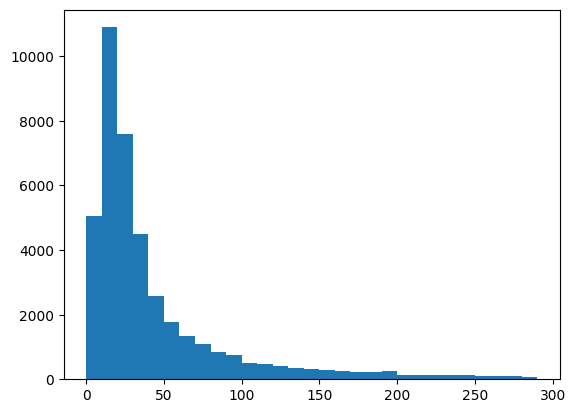

In [165]:
plt.hist([item.price for item in training_data], bins=range(0,300,10))

### Clearly we need to do a better job with data pre-precessing. but this will suffice for now.

### Current data is skewed so we will balance the datasets by taking in equal observations for each price point


In [31]:
from collections import defaultdict

slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

Text(0.5, 0, 'price buckets')

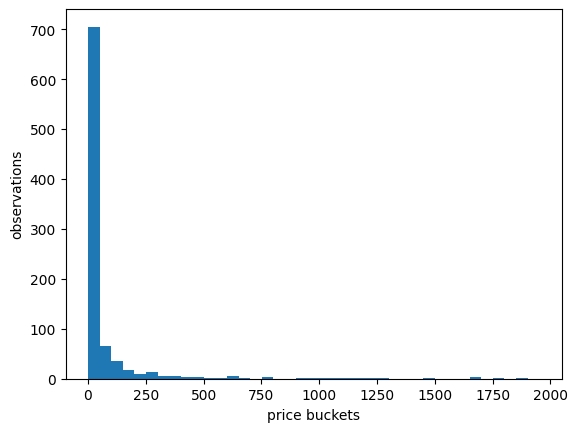

In [54]:
plt.hist([len(slots[i]) for i in range(1,1000)], bins=range(1,2000,50))
plt.ylabel("observations")
plt.xlabel("price buckets")

In [52]:
min(list(slots.keys())),max(list(slots.keys()))

(1, 999)

In [ ]:
# lets curate a dataset for all prices less than 100
samples = []
for i in range(1,101):
    samples.extend(slots[i]) # extend as each slots[i] is a list, and we want samples to be a list not list of lists!
    

In [65]:
len(samples)

73723

In [71]:
print(samples[0].price)
print()
print(samples[0].test_prompt())
print()
print(samples[0].prompt)

1.23

How much does this cost to the nearest dollar?

OR Dryer Rear Bearing Support
or Dryer Rear Drum Bearing Support Cup. The bearing support cup helps the drum rotate smoothly and quietly. This part works with the following brands Frigidaire, White Westinghouse, Kelvinator, Gibson, Kenmore, Sears, Tappan, & Electrolux. Replaces Old Numbers 175427 774936 85-951 DE727 or Dryer Rear Drum Bearing Support Cup. The bearing support cup helps the drum rotate smoothly and quietly. This part works with the following brands Frigidaire, White Westinghouse, Kelvinator, Gibson, Kenmore, Sears, Tappan, & Electrolux. Replaces Old Numbers; 175427 774936 85-951 DE727 Manufacturer ERP, Part Weight 

Price is $

How much does this cost to the nearest dollar?

OR Dryer Rear Bearing Support
or Dryer Rear Drum Bearing Support Cup. The bearing support cup helps the drum rotate smoothly and quietly. This part works with the following brands Frigidaire, White Westinghouse, Kelvinator, Gibson, Kenmore, Sears,

(array([  16.,   64.,  137.,  335.,  773., 1461., 2382., 2864., 2835.,
        3757., 2195., 2567., 2496., 2142., 2436., 2032., 1856., 1660.,
        1663., 2742., 1060., 1668., 1211., 1188., 1791., 1130., 1094.,
         950., 1036., 1808.,  606.,  630.,  788.,  589.,  991.,  745.,
         635.,  559.,  616., 1441.,  324.,  352.,  460.,  371.,  614.,
         420.,  281.,  302.,  401., 1130.,  183.,  230.,  290.,  242.,
         460.,  238.,  222.,  201.,  356.,  913.,  142.,  147.,  195.,
         202.,  375.,  215.,  132.,  163.,  295.,  760.,  108.,  143.,
         163.,  126.,  292.,  158.,  110.,  125.,  273.,  671.,   94.,
         100.,  116.,  109.,  278.,  108.,   88.,  139.,  254.,  650.,
          73.,   75.,   97.,   73.,  194.,  104.,  103.,  124.,  419.,
         791.]),
 array([  0.99  ,   1.9851,   2.9802,   3.9753,   4.9704,   5.9655,
          6.9606,   7.9557,   8.9508,   9.9459,  10.941 ,  11.9361,
         12.9312,  13.9263,  14.9214,  15.9165,  16.9116,  17.9067

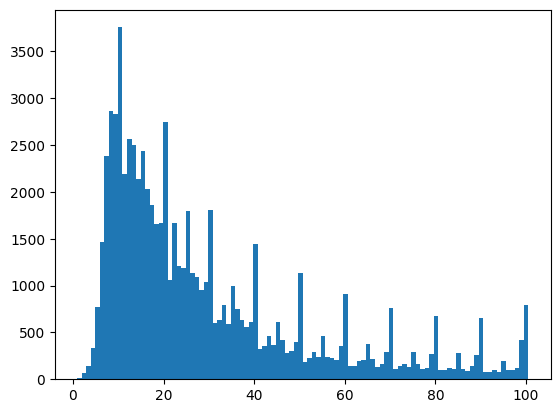

In [72]:
prices = [float(item.price) for item in samples]
plt.hist(prices, bins=100)

# splitting the data into test and train split


In [74]:
import random
random.seed(42)
random.shuffle(samples)
train = samples[:73_000]
test = samples[73_000:]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 73,000 items and test set of 723 items


In [75]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

4 Pack Mini Stage Light Clamp OD Tubing/Pipe Aluminum Mounting Truss Clamps Max Heavy Duty Load 22lbs
--0.8 Inch stage light clamps, Max Load is 22lb and Fit the Pipe Diameter measure your pipe before you purchase --Completely wrap around truss for added security and stability --Threaded Bolt 5 mm, apply to Aperture of the lamp --Completely Wrap Around the Truss to make Sure Security and Stability ---Suitable for Hooking LED Stage Lights Manufacturer Gchee, Weight 5.6 ounces, Dimensions 4.7 x 4.2 x 1.4 inches, Style Heavy Duty, Material Aluminum, Rank Musical Instruments 33307, Stage Lights 657, Available May 20, 2019

Price is $19.00


In [77]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

Lanikai LGB-S Padded Soprano Ukulele Gig Bag
This high quality padded gig bag is the perfect solution for all your ukulele storage and protection needs! With thick foam padding, reinforced stitching, ergonomic rubber handle, and spacious front storage pocket the Lanikai LGB Ukulele Gig Bag is the perfect choice to protect your ukulele for travel, storage, or wherever your adventures take you! Soprano Sized Durable Foam Padding Ergonomic Rubber Handle Spacious Storage Pocket Lanikai Logo Weight 9.6 ounces, Dimensions 21.5 x 3.5 x 7.5 inches, model number LGB-S, Rank Musical Instruments Acoustic Guitar Bags & Cases 566, Is Discontinued No, Available November 3,

Price is $


# upload the dataset to hugging face and pickle the files to be used locally


In [78]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [79]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [80]:
HF_USER = "BharathkReddy"
DATASET_NAME = f"{HF_USER}/amazonreview-data-appliances_and_musicalinstruments"
dataset.push_to_hub(DATASET_NAME, private=False)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/73 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/BharathkReddy/amazonreview-data-appliances_and_musicalinstruments/commit/12988682e462d9298c558c3fcbef3db49707088b', commit_message='Upload dataset', commit_description='', oid='12988682e462d9298c558c3fcbef3db49707088b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/BharathkReddy/amazonreview-data-appliances_and_musicalinstruments', endpoint='https://huggingface.co', repo_type='dataset', repo_id='BharathkReddy/amazonreview-data-appliances_and_musicalinstruments'), pr_revision=None, pr_num=None)

In [89]:
# Let's pickle the training and test dataset so we don't have to execute all this code next time
import pickle

with open('data/train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('data/test.pkl', 'wb') as file:
    pickle.dump(test, file)